In [1]:
!pip install datasets
!pip install peft
!pip install -U bitsandbytes
! pip install torch

In [37]:
import time
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, logging, BitsAndBytesConfig

logging.set_verbosity_error()
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

device

'mps'

In [39]:
def print_count_parameters(model):
    """
    This function takes a PyTorch model and returns the number of trainable and non-trainable parameters.

    Args:
    model (torch.nn.Module): The PyTorch model to inspect.

    """
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)

    percent_trainable = (trainable_params / (trainable_params + non_trainable_params)) * 100
    percent_frozen = 100 - percent_trainable

    print('Total Parameters:', trainable_params + non_trainable_params)
    print('Trainable:', trainable_params, f'({percent_trainable:.2f}%)')
    print('Frozen:', non_trainable_params, f'({percent_frozen:.2f}%)')


def calculate_model_size_in_gb(model):
    total_size = 0
    for param in model.parameters():
        # Each parameter's size is the number of elements * size of each element in bytes
        param_size = param.numel() * param.element_size()  # numel() gives number of elements, element_size() gives size of one element
        total_size += param_size

    # Convert to gigabytes (GB) from bytes
    total_size_in_gb = total_size / (1024 ** 3)
    return total_size_in_gb



In [40]:
# Load the GPT-Large tokenizer and model
model_name = "openai-community/gpt2-large"

tokenizer = AutoTokenizer.from_pretrained(model_name)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token  # Using eos_token as the pad_token if it's not defined


In [41]:
class SST2Dataset(Dataset):
    def __init__(self, dataset, tokenizer, max_length):
        self.dataset = dataset
        self.tokenizer = tokenizer

        self.max_length = max_length

        # Tokenize the sentences in the dataset during initialization
        self.tokenized_data = self.tokenizer(
            [example['sentence'] for example in self.dataset],
            padding=True,
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )

        # Store the labels separately
        self.labels = [example['label'] for example in self.dataset]


    def __getitem__(self, idx):
        input_ids = self.tokenized_data['input_ids'][idx]
        attention_mask = self.tokenized_data['attention_mask'][idx]
        label = self.labels[idx]
        return input_ids, attention_mask, label

    def __len__(self):
        # Return the total number of samples
        return len(self.dataset)




In [42]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, ignore_mismatched_sizes=True).to(device)
model.config.pad_token_id = tokenizer.pad_token_id

The original model size is 2.88 GB. But later when we apply QLoRA, this size will be reduced drastically.

In [44]:
original_model_size = calculate_model_size_in_gb(model)
print(f'Original model size: {original_model_size:.2f} GB')

Original model size: 2.88 GB


In [9]:
# Load the SST-2 dataset
dataset = load_dataset("glue", "sst2")

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/importlib/__init__.py:126: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.22.4)
  return _bootstrap._gcd_import(name[level:], package, level)


In [10]:
dataset_15000 = dataset['train'].select(range(15000))

In [30]:
train_data = SST2Dataset(dataset_15000, tokenizer=tokenizer, max_length=32)
val_data = SST2Dataset(dataset['validation'], tokenizer=tokenizer, max_length=32)
test_data = SST2Dataset(dataset['test'], tokenizer=tokenizer, max_length=32)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

We can see the number of parameters in the model (7.7B) and all of them are trainable. 

In [13]:
print_count_parameters(model)

Total Parameters: 774032640
Trainable: 774032640 (100.00%)
Frozen: 0 (0.00%)


In [32]:
def train_model(model, train_loader, epochs, lr=5e-5, print_loss_per_step=0, optimizer='adam'):
    accuracies, losses = [], []
    if optimizer == 'adam':
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    elif optimizer == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    
    model.train()
    for i in range(epochs):
        step = 0
        total_loss = 0
        predictions, truth_values = [], []
        for input_ids, attention_mask, labels in tqdm(train_loader):
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            batch_predictions = torch.argmax(outputs.logits, dim=1).tolist()
            predictions.extend(batch_predictions)
            truth_values.extend(labels.tolist())

            # Perform backpropagation
            loss.backward()

            # Update the weights
            optimizer.step()

            # Clear the gradients
            optimizer.zero_grad()

            if print_loss_per_step > 0 and step % print_loss_per_step == 0:
                print(f"Step {step}, Loss: {loss.item()}")
            step += 1
            total_loss += loss.item()



        loss = total_loss / len(train_loader)

        predictions = np.array(predictions)
        truth_values = np.array(truth_values)
        accuracy = np.mean(predictions == truth_values)
        print(f"Epoch {i+1}, Loss: {loss}")
        print(f"Accuracy: {accuracy}")
        print('--'*20)

        accuracies.append(accuracy)
        losses.append(loss)
    return accuracies, losses



In [13]:
def evaluate_model(model, data_loader):
    model.eval()
    predictions, truth_values = [], []
    with torch.no_grad():
        for input_ids, attention_mask, labels in tqdm(data_loader):
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            batch_predictions = torch.argmax(outputs.logits, dim=1).tolist()
            predictions.extend(batch_predictions)
            truth_values.extend(labels.tolist())

    predictions = np.array(predictions)
    truth_values = np.array(truth_values)
    accuracy = np.mean(predictions == truth_values)

    return round(float(accuracy), 2)

# Full fine-tuning

We fine tuning the model using the entire set of parameters. We can see the loss going down. An epoch takes aroung 3.5 mins!

In [16]:
start = time.time()

full_tuning_accuracy, full_tuning_loss = train_model(model, train_loader, epochs=5)

end = time.time()

full_tuning_time = end - start
print(f"Training time: {full_tuning_time:.2f} seconds")

100%|██████████| 469/469 [03:30<00:00,  2.23it/s]


Epoch 1, Loss: 0.2900665488197351
Accuracy: 0.8822666666666666
----------------------------------------


100%|██████████| 469/469 [03:29<00:00,  2.24it/s]


Epoch 2, Loss: 0.12157170538619748
Accuracy: 0.9573333333333334
----------------------------------------


100%|██████████| 469/469 [03:29<00:00,  2.24it/s]


Epoch 3, Loss: 0.06630882213630879
Accuracy: 0.9786
----------------------------------------


100%|██████████| 469/469 [03:29<00:00,  2.24it/s]


Epoch 4, Loss: 0.05197187018385137
Accuracy: 0.9830666666666666
----------------------------------------


100%|██████████| 469/469 [03:29<00:00,  2.24it/s]

Epoch 5, Loss: 0.04039179664488677
Accuracy: 0.9875333333333334
----------------------------------------
Training time: 1051.13 seconds


In [6]:
full_tuning_time = 1051.13

The model has 90% accuracy on the test set. Clearly these is overfitting to some extent since the training accuracy is 99%.<br>
This can easily happen when training a model with a large number of parameters on a relatively small dataset.


In [17]:
val_accuracy = evaluate_model(model, val_loader)
print(f"Full Tuning Validation Accuracy: {val_accuracy}")

100%|██████████| 28/28 [00:02<00:00,  9.61it/s]

Full Tuning Validation Accuracy: 0.9


# LoRA Fine Tuning with peft from HuggingFace

In [41]:
from peft import get_peft_model, LoraConfig, TaskType


lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,  # Sequence classification task
    r=4,  # Low-rank dimension
    lora_alpha=4,  # Alpha scaling factor
    lora_dropout=0.1,  # Dropout rate to use in LoRA
    target_modules=["c_attn"]  # Apply LoRA to attention layers (can be adjusted)
)

In [19]:
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)
model.config.pad_token_id = tokenizer.pad_token_id

model = get_peft_model(model, lora_config).to(device)


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/peft/tuners/lora/layer.py:1150: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


LoRA freezes the original parameters and introduces a small set of new parameters. The new parameters are only 0.1% of the total parameters.

In [20]:
print_count_parameters(model)

Total Parameters: 774772480
Trainable: 739840 (0.10%)
Frozen: 774032640 (99.90%)


Using LoRA, the epoch time is reduced from 3.5 mins to 2 mins!


In [21]:
start = time.time()

lora_accuracy, lora_loss = train_model(model, train_loader, lr=5e-5, epochs=5)

end = time.time()

lora_tuning_time = end - start
print(f"Training time: {lora_tuning_time:.2f} seconds")

100%|██████████| 469/469 [02:03<00:00,  3.80it/s]


Epoch 1, Loss: 0.42448635796494066
Accuracy: 0.7961333333333334
----------------------------------------


100%|██████████| 469/469 [02:03<00:00,  3.80it/s]


Epoch 2, Loss: 0.2578021030881003
Accuracy: 0.8970666666666667
----------------------------------------


100%|██████████| 469/469 [02:03<00:00,  3.80it/s]


Epoch 3, Loss: 0.23182660384155285
Accuracy: 0.9087333333333333
----------------------------------------


100%|██████████| 469/469 [02:03<00:00,  3.80it/s]


Epoch 4, Loss: 0.21926294344225164
Accuracy: 0.9144
----------------------------------------


100%|██████████| 469/469 [02:03<00:00,  3.80it/s]

Epoch 5, Loss: 0.20325684768241098
Accuracy: 0.9216666666666666
----------------------------------------
Training time: 616.58 seconds


In [7]:
lora_tuning_time = 616.58

In [22]:
saved_time = full_tuning_time - lora_tuning_time
saved_percent = (saved_time / full_tuning_time) * 100

print(f"LoRA saved {saved_time:.2f} seconds ({saved_percent:.2f}%) in training time.")

LoRA saved 434.55 seconds (41.34%) in training time.


The training accuracy is 92% while validation accuracy is 91%. <br>
LoRA models performs slightly better than the original model. Since we are tuning only 0.1% of the original parameters, overfitting is not a problem we face.

In [23]:
lora_val_accuracy = evaluate_model(model, val_loader)
print(f"LoRA Validation Accuracy: {lora_val_accuracy}")

100%|██████████| 28/28 [00:03<00:00,  8.87it/s]

LoRA Validation Accuracy: 0.91


## Custom Implementations for LoRA and DoRA

In [24]:
class LoRA(nn.Module):
    def __init__(self, original_layer, alpha, rank=8):
        super(LoRA, self).__init__()

        # Store the original layer's weight
        self.original_weight = original_layer.weight
        self.alpha = alpha

        in_features = original_layer.weight.shape[0]
        out_features = original_layer.weight.shape[1]

        # Perform weight decomposition into two low-rank matrices A and B
        # We initialize A and B with random values
        self.rank = rank

        std_dev = 1 / torch.sqrt(torch.tensor(rank).float())
        self.A = nn.Parameter(torch.randn(in_features, rank) * std_dev)
        self.B = nn.Parameter(torch.zeros(rank, out_features))

        self.original_weight.requires_grad = False

    def forward(self, x):
        # Approximate the original weight as the product of A and B
        low_rank_weight = self.alpha * torch.matmul(self.A, self.B)
        adapted_weight = self.original_weight + low_rank_weight

        # Apply the adapted weight to the input
        return torch.matmul(x, adapted_weight)

class DoRA(nn.Module):
    def __init__(self, original_layer, alpha, rank=8):
        super(DoRA, self).__init__()

        # Store the original layer's weight
        self.original_weight = original_layer.weight
        self.alpha = alpha

        in_features = original_layer.weight.shape[0]
        out_features = original_layer.weight.shape[1]


        # Perform weight decomposition into two low-rank matrices A and B
        # We initialize A and B with random values
        self.rank = rank

        std_dev = 1 / torch.sqrt(torch.tensor(rank).float())
        self.A = nn.Parameter(torch.randn(in_features, rank) * std_dev)
        self.B = nn.Parameter(torch.zeros(rank, out_features))
        self.m = nn.Parameter(torch.ones(1, out_features))

        self.original_weight.requires_grad = False

    def forward(self, x):
        # Approximate the original weight as the product of A and B
        low_rank_weight = self.alpha * torch.matmul(self.A, self.B)

        low_rank_weight_norm = low_rank_weight / (low_rank_weight.norm(p=2, dim=1, keepdim=True) + 1e-9)

        # Add the original (frozen) weight back to the low-rank adaptation
        low_rank_weight = self.m * low_rank_weight_norm
        adapted_weight = self.original_weight + low_rank_weight

        # Apply the adapted weight to the input
        return torch.matmul(x, adapted_weight)

## Adding the LoRA/DoRA layers to the model

In [25]:
from transformers.pytorch_utils import Conv1D
def apply_peft_to_layer(module, alpha=4, rank=8, type='lora'):
    """
    Recursively applies LoRA/DoRA to the appropriate layers in the model.

    Args:
        module: The current module to examine and possibly replace.
        alpha: Scaling factor for DoRA.
        rank: The rank of the low-rank adaptation.
        type: The type of PEFT to apply ('lora' or 'dora').

    Returns:
        None (modifies the module in place).
    """
    peft_module = LoRA if type == 'lora' else DoRA
    for name, child_module in module.named_children():
        if isinstance(child_module, Conv1D) and 'c_attn' in name:
            # Replace with DoRA version of the module
            setattr(module, name, peft_module(child_module, alpha=alpha, rank=rank))

        # If the module has children, apply the function recursively
        if len(list(child_module.children())) > 0:
            apply_peft_to_layer(child_module, alpha, rank, type)

def get_custom_peft_model(alpha=4, rank=8, type='lora'):
    """
    Load the model and apply LoRA/DoRA recursively to all applicable layers.

    Args:
        model_name: The name of the model to load.
        alpha: Scaling factor for DoRA.
        rank: Rank for low-rank adaptation in DoRA.

    Returns:
        The model with LoRA/DoRA applied.
    """
    # Load the model and set the pad token ID
    model = AutoModelForSequenceClassification.from_pretrained(model_name, ignore_mismatched_sizes=True).to(device)
    model.config.pad_token_id = tokenizer.pad_token_id
    for param in model.parameters():
        param.requires_grad = False

    # Apply DoRA recursively to all relevant layers
    apply_peft_to_layer(model, alpha=alpha, rank=rank, type=type)

    return model

## Custom LoRA Implementation Results

In [26]:
model = get_custom_peft_model(alpha=4, rank=4, type='lora').to(device)
print_count_parameters(model)

Total Parameters: 774631680
Trainable: 737280 (0.10%)
Frozen: 773894400 (99.90%)


In [27]:
start = time.time()

custom_lora_accuracy, custom_lora_loss = train_model(model, train_loader, epochs=5)

end = time.time()

custom_lora_tuning_time = end - start
print(f"Training time: {custom_lora_tuning_time:.2f} seconds")

100%|██████████| 469/469 [02:08<00:00,  3.64it/s]


Epoch 1, Loss: 0.31657742771671527
Accuracy: 0.8675333333333334
----------------------------------------


100%|██████████| 469/469 [02:08<00:00,  3.64it/s]


Epoch 2, Loss: 0.2059048199251707
Accuracy: 0.9202
----------------------------------------


100%|██████████| 469/469 [02:08<00:00,  3.64it/s]


Epoch 3, Loss: 0.16856365183443783
Accuracy: 0.9354
----------------------------------------


100%|██████████| 469/469 [02:08<00:00,  3.64it/s]


Epoch 4, Loss: 0.13839502774897827
Accuracy: 0.9478666666666666
----------------------------------------


100%|██████████| 469/469 [02:08<00:00,  3.64it/s]

Epoch 5, Loss: 0.11934291280960954
Accuracy: 0.9566
----------------------------------------
Training time: 644.19 seconds


In [58]:
custom_lora_tuning_time = 644.19

In [28]:
saved_time = full_tuning_time - custom_lora_tuning_time
saved_percent = (saved_time / full_tuning_time) * 100

print(f"Custom LoRA saved {saved_time:.2f} seconds ({saved_percent:.2f}%) in training time.")

Custom LoRA saved 406.95 seconds (38.72%) in training time.


In [29]:
custom_lora_val_accuracy = evaluate_model(model, val_loader)
print(f"Custom LoRA Validation Accuracy: {lora_val_accuracy}")

100%|██████████| 28/28 [00:03<00:00,  8.93it/s]

Custom LoRA Validation Accuracy: 0.91


# DoRA Fine-tuning

In [48]:
model = get_custom_peft_model(alpha=4, rank=4, type='dora').to(device)
print_count_parameters(model)

Total Parameters: 774769920
Trainable: 875520 (0.11%)
Frozen: 773894400 (99.89%)


In [49]:
start = time.time()

dora_accuracy, dora_loss = train_model(model, train_loader, lr=0.005, epochs=5)

end = time.time()

dora_tuning_time = end - start
print(f"Training time: {dora_tuning_time:.2f} seconds")

100%|██████████| 469/469 [02:31<00:00,  3.09it/s]


Epoch 1, Loss: 0.5924898334530625
Accuracy: 0.7034666666666667
----------------------------------------


100%|██████████| 469/469 [02:31<00:00,  3.09it/s]


Epoch 2, Loss: 0.32648179105032227
Accuracy: 0.8575333333333334
----------------------------------------


100%|██████████| 469/469 [02:31<00:00,  3.09it/s]


Epoch 3, Loss: 0.2531521533057888
Accuracy: 0.8965333333333333
----------------------------------------


100%|██████████| 469/469 [02:31<00:00,  3.09it/s]


Epoch 4, Loss: 0.20817177838036247
Accuracy: 0.9143333333333333
----------------------------------------


100%|██████████| 469/469 [02:31<00:00,  3.09it/s]

Epoch 5, Loss: 0.17597557757216603
Accuracy: 0.9312666666666667
----------------------------------------
Training time: 758.82 seconds


In [8]:
dora_tuning_time = 758.82

In [50]:
saved_time = full_tuning_time - dora_tuning_time
saved_percent = (saved_time / full_tuning_time) * 100

print(f"DoRA saved {saved_time:.2f} seconds ({saved_percent:.2f}%) in training time.")

DoRA saved 292.31 seconds (27.81%) in training time.


In [51]:
dora_val_accuracy = evaluate_model(model, val_loader)
print(f"DoRA Validation Accuracy: {dora_val_accuracy}")

100%|██████████| 28/28 [00:03<00:00,  8.40it/s]

DoRA Validation Accuracy: 0.9


# QLoRA

QLoRA uses quantization to reduce the size of the model by storing the parameter in 4 bits (sometimes 8) instead of the normal 32 bits. 

In [51]:
# Load the model using 4-bit quantization
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
)

# Load the model with the updated quantization config
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    quantization_config=quantization_config,  # Pass the quantization configuration
    device_map="auto",  # Automatically map the model to the available devices (e.g., GPU)
)
model.config.pad_token_id = tokenizer.pad_token_id

model = get_peft_model(model, lora_config)

In [52]:
print_count_parameters(model)

Total Parameters: 420878080
Trainable: 739840 (0.18%)
Frozen: 420138240 (99.82%)


Model size was reduce from 2.88 GB to 0.46 GB!

In [53]:
quantized_model_size = calculate_model_size_in_gb(model)
saved_memory = original_model_size - quantized_model_size

saved_memory_percent = (saved_memory / original_model_size) * 100
print(f"Quantized model size {quantized_model_size:.2f} GB")
print(f"Quantized model saved {saved_memory:.2f} GB ({saved_memory_percent:.2f}%) in memory.")


Quantized model size 0.46 GB
Quantized model saved 2.43 GB (84.20%) in memory.


In [54]:
start = time.time()

qlora_accuracy, qlora_loss = train_model(model, train_loader, epochs=5, optimizer='sgd', lr=0.005)

end = time.time()

qlora_tuning_time = end - start
print(f"Training time: {qlora_tuning_time:.2f} seconds")

100%|██████████| 469/469 [01:02<00:00,  7.45it/s]


Epoch 1, Loss: 0.5588040545042644
Accuracy: 0.7085333333333333
----------------------------------------


100%|██████████| 469/469 [01:02<00:00,  7.47it/s]


Epoch 2, Loss: 0.4497281137559968
Accuracy: 0.7913333333333333
----------------------------------------


100%|██████████| 469/469 [01:03<00:00,  7.42it/s]


Epoch 3, Loss: 0.40731583780317165
Accuracy: 0.8181333333333334
----------------------------------------


100%|██████████| 469/469 [01:02<00:00,  7.46it/s]


Epoch 4, Loss: 0.3726286084921375
Accuracy: 0.8406
----------------------------------------


100%|██████████| 469/469 [01:03<00:00,  7.42it/s]

Epoch 5, Loss: 0.3312622590868204
Accuracy: 0.8559333333333333
----------------------------------------
Training time: 315.10 seconds


In [9]:
qlora_tuning_time = 315.10

In [55]:
qlora_val_accuracy = evaluate_model(model, val_loader)
print(f"QLoRA Validation Accuracy: {qlora_val_accuracy}")

100%|██████████| 28/28 [00:01<00:00, 16.76it/s]

QLoRA Validation Accuracy: 0.86


# Visualization


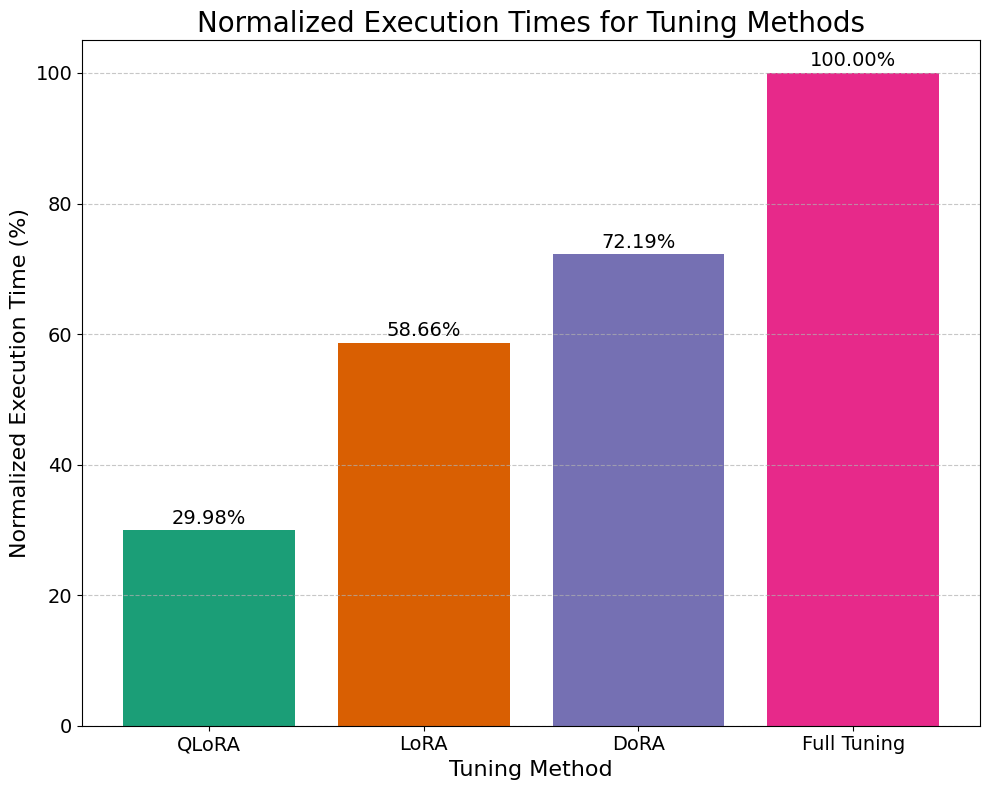

In [10]:
import matplotlib.pyplot as plt

# Example execution times (replace with actual values)
execution_times = {
    'Full Tuning': full_tuning_time,
    'LoRA': lora_tuning_time,
    'DoRA': dora_tuning_time,
    'QLoRA': qlora_tuning_time
}

# Normalizing execution times, mapping 'Full Tuning' to 100%
full_tuning_time = execution_times['Full Tuning']
normalized_times = {key: (value / full_tuning_time) * 100 for key, value in execution_times.items()}

# Sort the methods by normalized execution times
sorted_normalized_times = dict(sorted(normalized_times.items(), key=lambda item: item[1]))

# Extract sorted keys and values for plotting
sorted_methods = list(sorted_normalized_times.keys())
sorted_times = list(sorted_normalized_times.values())

# Create the sorted bar chart with a grid and a different color scheme
plt.figure(figsize=(10, 8))

# Use a different color scheme (e.g., 'Set2')
colors = plt.get_cmap('Dark2').colors

# Create the bar chart with a grid
plt.bar(sorted_methods, sorted_times, color=colors)

# Add grid to the background
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Add labels and title
plt.xlabel('Tuning Method', fontsize=16)
plt.ylabel('Normalized Execution Time (%)', fontsize=16)
plt.title('Normalized Execution Times for Tuning Methods', fontsize=20)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Display the values on the bars
for i, time in enumerate(sorted_times):
    plt.text(i, time + 1, f'{time:.2f}%', ha='center', fontsize=14)

# Display the plot
plt.tight_layout()
plt.savefig('./imgs/execution_times.png')
plt.show()

qlora_color = colors[0]
lora_color = colors[1]
dora_color = colors[2]
full_tuning_color = colors[3]


In [23]:
def area(r):
    return np.pi * (r ** 2)

In [26]:
import numpy as np
area(2/15) / area(1/3) 

0.16

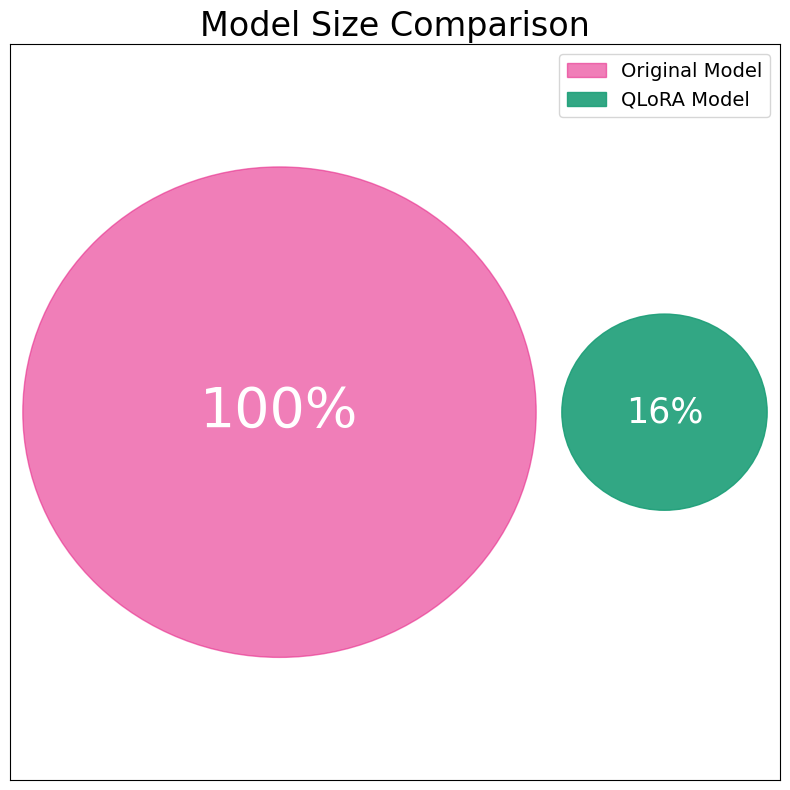

In [34]:
# Create a figure
fig, ax = plt.subplots(figsize=(8, 8))

# Plot two circles, the second one being 16% the size of the first
circle1 = plt.Circle((0.35, 0.5), 1/3, color=full_tuning_color, alpha=0.6, label='Original Model')
circle2 = plt.Circle((0.85, 0.5), 2/15, color=qlora_color, alpha=0.9, label='QLoRA Model')

# Add the circles to the plot
ax.add_artist(circle1)
ax.add_artist(circle2)

# Add text in the center of each circle
ax.text(0.35, 0.5, '100%', color='white', fontsize=40, ha='center', va='center')
ax.text(0.85, 0.5, '16%', color='white', fontsize=25, ha='center', va='center')

# Set axis limits to make the circles visible and mutually exclusive
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

# Add a title and legend
plt.title('Model Size Comparison', fontsize=24)
plt.legend(handles=[circle1, circle2], fontsize=14)

# Remove axis for a cleaner look
ax.set_xticks([])
ax.set_yticks([])

# Display the plot
plt.tight_layout()
plt.savefig('./imgs/model_size_comparison.png')
plt.show()

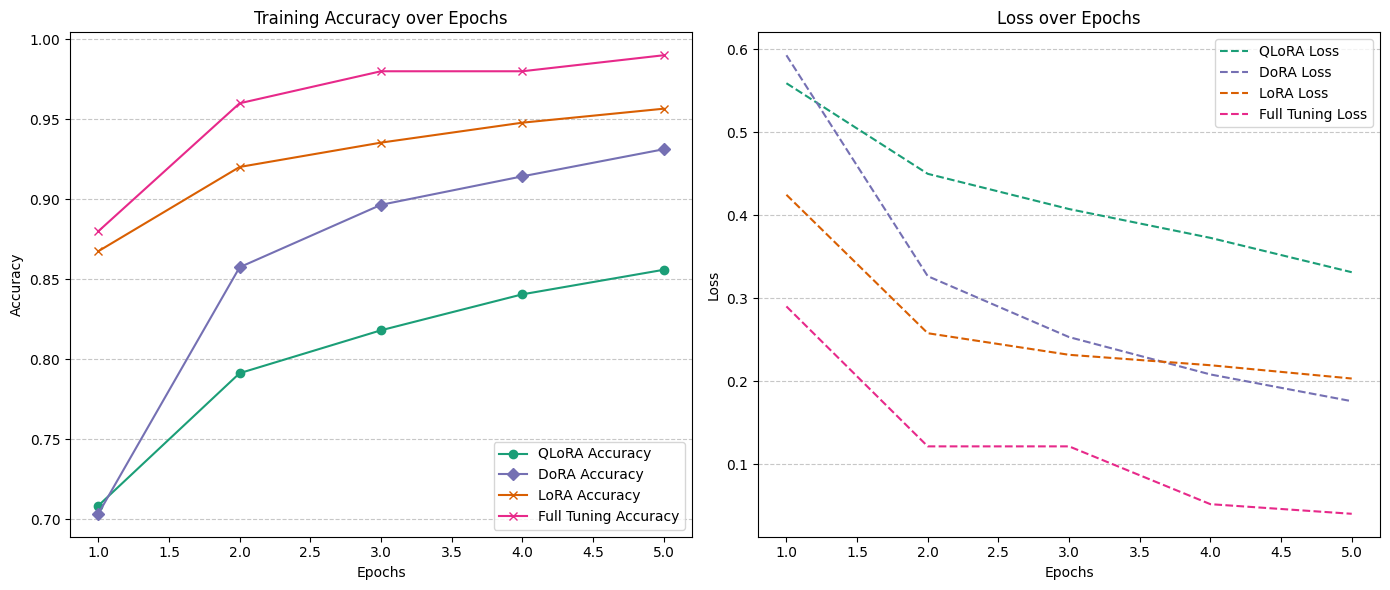

In [167]:
epochs = list(range(1, len(qlora_loss) + 1))

# Create two plots: one for loss and one for accuracy side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)
ax2.grid(True, axis='y', linestyle='--', alpha=0.7)

# Plot accuracy on the first subplot
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')

ax1.plot(epochs, qlora_accuracy, label='QLoRA Accuracy', marker='o', color=qlora_color)
ax1.plot(epochs, dora_accuracy, label='DoRA Accuracy', marker='D', color=dora_color)
ax1.plot(epochs, custom_lora_accuracy, label='LoRA Accuracy', marker='x', color=lora_color)
ax1.plot(epochs, full_tuning_accuracy, label='Full Tuning Accuracy', marker='x', color=full_tuning_color)


ax1.set_title('Training Accuracy over Epochs')
ax1.legend(loc='lower right')

# Plot loss on the second subplot
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.plot(epochs, qlora_loss, label='QLoRA Loss', linestyle='--', color=qlora_color)
ax2.plot(epochs, dora_loss, label='DoRA Loss', linestyle='--', color=dora_color)
ax2.plot(epochs, lora_loss, label='LoRA Loss', linestyle='--', color=lora_color)
ax2.plot(epochs, full_tuning_loss, label='Full Tuning Loss', linestyle='--', color=full_tuning_color)
ax2.set_title('Loss over Epochs')
ax2.legend(loc='upper right')


# Adjust layout to make sure plots do not overlap
plt.tight_layout()

# Display the plots
plt.show()

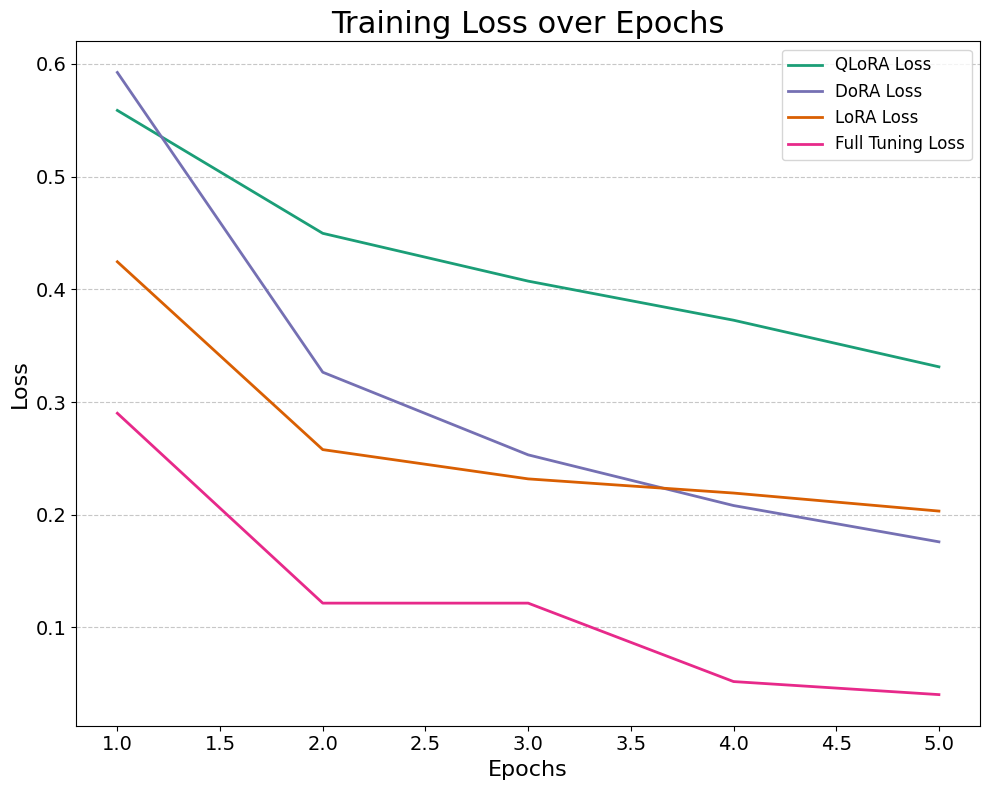

In [160]:
epochs = list(range(1, len(qlora_loss) + 1))

# Create the loss plot
fig, ax = plt.subplots(figsize=(10, 8))

# Add grid for the y-axis
ax.grid(True, axis='y', linestyle='--', alpha=0.7)
colors = plt.get_cmap('Dark2').colors


# Plot loss on the subplot
ax.set_xlabel('Epochs', fontsize=16)
ax.set_ylabel('Loss', fontsize=16)
ax.plot(epochs, qlora_loss, label='QLoRA Loss', color=colors[0], linewidth=2)
ax.plot(epochs, dora_loss, label='DoRA Loss', color=colors[2], linewidth=2)
ax.plot(epochs, lora_loss, label='LoRA Loss', color=colors[1], linewidth=2)
ax.plot(epochs, full_tuning_loss, label='Full Tuning Loss', color=colors[3], linewidth=2)

# Set title and legend with appropriate font size
ax.set_title('Training Loss over Epochs', fontsize=22)
ax.legend(loc='upper right', fontsize=12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# Adjust layout and display the plot
plt.tight_layout()
plt.savefig('./imgs/loss_plot.png')
plt.show()

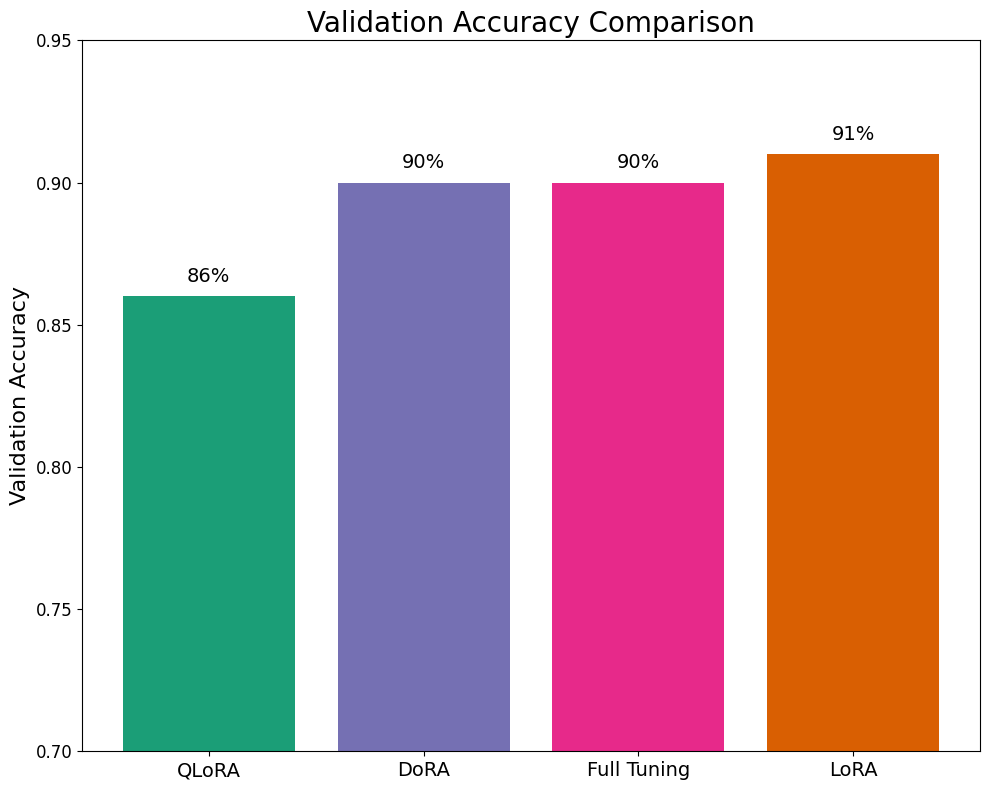

In [36]:
# Example validation accuracy data (replace with actual data)
val_accuracies = {
    'QLoRA': 0.86,
    'LoRA': 0.91,
    'DoRA': 0.9,
    'Full Tuning': 0.9,
}

# Sort validation accuracies from low to high
sorted_accuracies = dict(sorted(val_accuracies.items(), key=lambda item: item[1]))

# Extract the names and values for plotting
names = list(sorted_accuracies.keys())
values = list(sorted_accuracies.values())

# Use Dark2 colormap and normalize the values
norm = plt.Normalize(min(values)-0.05, max(values))
colors = [qlora_color, dora_color, full_tuning_color, lora_color]

# Create the vertical bar chart
plt.figure(figsize=(10, 8))
plt.ylim(0.7, 0.95)  # Adjust the y-axis range
plt.bar(names, values, color=colors)

# Annotate the bars with the exact values
for index, value in enumerate(values):
    plt.text(index, value + 0.005, f'{int(value*100)}%', ha='center', fontsize=14) 

# Add labels and title
plt.ylabel('Validation Accuracy', fontsize=16)
plt.title('Validation Accuracy Comparison', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)

# Display the plot
plt.tight_layout()
plt.savefig('./imgs/val_accuracy_comparison.png')
plt.show()